#**스마트폰 센서 데이터 기반 모션 분류**
# 단계1 : 탐색적 데이터 분석

## 0.미션

### (1) 미션1
수많은 feature들을 모두 살펴보는 것은 과도한 시간과 노력이 필요합니다. 그래서 여러분은 **선택과 집중**을 해야 합니다.
* 1) **기본 모델을 생성**한 후 **변수 중요도**를 구합니다.   
    * random forest 알고리즘 사용을 권장합니다.
* 2) **중요한 feature와 중요하지 않은 feature 상위 N개를 선정**하고, 이들을 대상으로 EDA 수행. (kde plot?)


### (2) 미션2
다음의 case에 맞게 feature 및 feature 그룹 중요도를 기반으로 탐색적 데이터 분석을 수행하시오.
* Target을 **정적/동적 행동**으로 구분
    * 6개의 행동은 2개의 그룹(정적행동, 동적행동)으로 나뉩니다.  
    * 어떤 feature 가 2개 class 그룹(정적행동, 동적행동)를 구분하는데 중요한지를 찾아보고 탐색해봅시다.


## 1.환경설정

* 세부 요구사항
    - 경로 설정 : 로컬 수행(Ananconda)
        * 제공된 압축파일을 다운받아 압축을 풀고
        * anaconda의 root directory(보통 C:/Users/< ID > 에 project3_1 폴더를 만들고, 복사해 넣습니다.
    - 기본적으로 필요한 라이브러리를 import 하도록 코드가 작성되어 있습니다.
        * 필요하다고 판단되는 라이브러리를 추가하세요.


### (1) 라이브러리 로딩

* 라이브러리 로딩

In [366]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import joblib

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

* 제공 함수 생성
    * 변수 중요도를 시각화할 수 있는 함수를 제공합니다.
    * 입력 :
        * importance : 트리모델의 변수 중요도(예: model.feature_importances_)
        * names : 변수 이름 목록(예 : x_train.columns
        * result_only  : 변수 중요도 순으로 데이터프레임만 return할지, 그래프도 포함할지 결정. False이면 결과 데이터프레임 + 그래프
        * topn : 중요도 상위 n개만 표시. all 이면 전체.
    * 출력 :
        * 중요도 그래프 : 중요도 내림차순으로 정렬
        * 중요도 데이터프레임 : 중요도 내림차순으로 정렬

In [368]:
# 변수의 특성 중요도 계산하기
def plot_feature_importance(importance, names, result_only = False, topn = 'all'):
    feature_importance = np.array(importance)
    feature_name = np.array(names)

    data={'feature_name':feature_name,'feature_importance':feature_importance}
    fi_temp = pd.DataFrame(data)

    #변수의 특성 중요도 순으로 정렬하기
    fi_temp.sort_values(by=['feature_importance'], ascending=False,inplace=True)
    fi_temp.reset_index(drop=True, inplace = True)

    if topn == 'all' :
        fi_df = fi_temp.copy()
    else :
        fi_df = fi_temp.iloc[:topn]

    #변수의 특성 중요도 그래프로 그리기
    if result_only == False :
        plt.figure(figsize=(10,20))
        sns.barplot(x='feature_importance', y='feature_name', data = fi_df)

        plt.xlabel('importance')
        plt.ylabel('feature name')
        plt.grid()

    return fi_df

### (2) 데이터 불러오기

* 주어진 데이터셋
    * data01_train.csv : 학습 및 검증용
    * data01_test.csv : 테스트용

* 세부 요구사항
    * 칼럼 삭제 : data01_train.csv와 data01_test.csv 에서 'subject' 칼럼은 불필요하므로 삭제합니다.

In [371]:
data_tr = pd.read_csv('data01_train.csv')
data_te = pd.read_csv('data01_test.csv')

In [372]:
data_tr.head()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",subject,Activity
0,0.288508,-0.009196,-0.103362,-0.988986,-0.962797,-0.967422,-0.989000,-0.962596,-0.965650,-0.929747,...,-0.816696,-0.042494,-0.044218,0.307873,0.072790,-0.601120,0.331298,0.165163,21,STANDING
1,0.265757,-0.016576,-0.098163,-0.989551,-0.994636,-0.987435,-0.990189,-0.993870,-0.987558,-0.937337,...,-0.693515,-0.062899,0.388459,-0.765014,0.771524,0.345205,-0.769186,-0.147944,15,LAYING
2,0.278709,-0.014511,-0.108717,-0.997720,-0.981088,-0.994008,-0.997934,-0.982187,-0.995017,-0.942584,...,-0.829311,0.000265,-0.525022,-0.891875,0.021528,-0.833564,0.202434,-0.032755,11,STANDING
3,0.289795,-0.035536,-0.150354,-0.231727,-0.006412,-0.338117,-0.273557,0.014245,-0.347916,0.008288,...,-0.408956,-0.255125,0.612804,0.747381,-0.072944,-0.695819,0.287154,0.111388,17,WALKING
4,0.394807,0.034098,0.091229,0.088489,-0.106636,-0.388502,-0.010469,-0.109680,-0.346372,0.584131,...,-0.563437,-0.044344,-0.845268,-0.974650,-0.887846,-0.705029,0.264952,0.137758,17,WALKING_DOWNSTAIRS


In [373]:
data_te.head()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",subject,Activity
0,0.284379,-0.021981,-0.116683,-0.992490,-0.979640,-0.963321,-0.992563,-0.977304,-0.958142,-0.938850,...,-0.850065,-0.018043,0.092304,0.074220,-0.714534,-0.671943,-0.018351,-0.185733,22,SITTING
1,0.277440,-0.028086,-0.118412,-0.996620,-0.927676,-0.972294,-0.997346,-0.931405,-0.971788,-0.939837,...,-0.613367,-0.022456,-0.155414,0.247498,-0.112257,-0.826816,0.184489,-0.068699,15,STANDING
2,0.305833,-0.041023,-0.087303,0.006880,0.182800,-0.237984,0.005642,0.028616,-0.236474,0.016311,...,0.394388,-0.362616,0.171069,0.576349,-0.688314,-0.743234,0.272186,0.053101,22,WALKING
3,0.276053,-0.016487,-0.108381,-0.995379,-0.983978,-0.975854,-0.995877,-0.985280,-0.974907,-0.941425,...,-0.841455,0.289548,0.079801,-0.020033,0.291898,-0.639435,-0.111998,-0.123298,8,SITTING
4,0.271998,0.016904,-0.078856,-0.973468,-0.702462,-0.869450,-0.979810,-0.711601,-0.856807,-0.920760,...,0.214219,0.010111,0.114179,-0.830776,-0.325098,-0.840817,0.116237,-0.096615,5,STANDING


In [374]:
# 칼럼 삭제
drop_cols = ['subject']
data_tr.drop(columns=drop_cols, inplace=True)
data_te.drop(columns=drop_cols, inplace=True)
# 확인
data_tr.head()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",Activity
0,0.288508,-0.009196,-0.103362,-0.988986,-0.962797,-0.967422,-0.989000,-0.962596,-0.965650,-0.929747,...,-0.487737,-0.816696,-0.042494,-0.044218,0.307873,0.072790,-0.601120,0.331298,0.165163,STANDING
1,0.265757,-0.016576,-0.098163,-0.989551,-0.994636,-0.987435,-0.990189,-0.993870,-0.987558,-0.937337,...,-0.237820,-0.693515,-0.062899,0.388459,-0.765014,0.771524,0.345205,-0.769186,-0.147944,LAYING
2,0.278709,-0.014511,-0.108717,-0.997720,-0.981088,-0.994008,-0.997934,-0.982187,-0.995017,-0.942584,...,-0.535287,-0.829311,0.000265,-0.525022,-0.891875,0.021528,-0.833564,0.202434,-0.032755,STANDING
3,0.289795,-0.035536,-0.150354,-0.231727,-0.006412,-0.338117,-0.273557,0.014245,-0.347916,0.008288,...,-0.004012,-0.408956,-0.255125,0.612804,0.747381,-0.072944,-0.695819,0.287154,0.111388,WALKING
4,0.394807,0.034098,0.091229,0.088489,-0.106636,-0.388502,-0.010469,-0.109680,-0.346372,0.584131,...,-0.157832,-0.563437,-0.044344,-0.845268,-0.974650,-0.887846,-0.705029,0.264952,0.137758,WALKING_DOWNSTAIRS


In [375]:
data_te.head()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",Activity
0,0.284379,-0.021981,-0.116683,-0.992490,-0.979640,-0.963321,-0.992563,-0.977304,-0.958142,-0.938850,...,-0.509523,-0.850065,-0.018043,0.092304,0.074220,-0.714534,-0.671943,-0.018351,-0.185733,SITTING
1,0.277440,-0.028086,-0.118412,-0.996620,-0.927676,-0.972294,-0.997346,-0.931405,-0.971788,-0.939837,...,-0.210792,-0.613367,-0.022456,-0.155414,0.247498,-0.112257,-0.826816,0.184489,-0.068699,STANDING
2,0.305833,-0.041023,-0.087303,0.006880,0.182800,-0.237984,0.005642,0.028616,-0.236474,0.016311,...,0.579587,0.394388,-0.362616,0.171069,0.576349,-0.688314,-0.743234,0.272186,0.053101,WALKING
3,0.276053,-0.016487,-0.108381,-0.995379,-0.983978,-0.975854,-0.995877,-0.985280,-0.974907,-0.941425,...,-0.566291,-0.841455,0.289548,0.079801,-0.020033,0.291898,-0.639435,-0.111998,-0.123298,SITTING
4,0.271998,0.016904,-0.078856,-0.973468,-0.702462,-0.869450,-0.979810,-0.711601,-0.856807,-0.920760,...,0.447577,0.214219,0.010111,0.114179,-0.830776,-0.325098,-0.840817,0.116237,-0.096615,STANDING


## 2.데이터 분석 : 기본정보 살펴보기

### (1) 기본정보 확인하기


* **세부 요구사항**
    - 불러온 데이터의 형태, 기초통계량, 정보 등을 확인합니다.

In [379]:
print(data_tr.shape)
print(data_te.shape)

(5881, 562)
(1471, 562)


In [380]:
print(data_tr.info())
print(data_te.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5881 entries, 0 to 5880
Columns: 562 entries, tBodyAcc-mean()-X to Activity
dtypes: float64(561), object(1)
memory usage: 25.2+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1471 entries, 0 to 1470
Columns: 562 entries, tBodyAcc-mean()-X to Activity
dtypes: float64(561), object(1)
memory usage: 6.3+ MB
None


In [381]:
print(data_tr.describe())
print(data_te.describe())

       tBodyAcc-mean()-X  tBodyAcc-mean()-Y  tBodyAcc-mean()-Z  \
count        5881.000000        5881.000000        5881.000000   
mean            0.274811          -0.017799          -0.109396   
std             0.067614           0.039422           0.058373   
min            -0.503823          -0.684893          -1.000000   
25%             0.262919          -0.024877          -0.121051   
50%             0.277154          -0.017221          -0.108781   
75%             0.288526          -0.010920          -0.098163   
max             1.000000           1.000000           1.000000   

       tBodyAcc-std()-X  tBodyAcc-std()-Y  tBodyAcc-std()-Z  tBodyAcc-mad()-X  \
count       5881.000000       5881.000000       5881.000000       5881.000000   
mean          -0.603138         -0.509815         -0.604058         -0.628151   
std            0.448807          0.501815          0.417319          0.424345   
min           -1.000000         -0.999844         -0.999667         -1.000000   


### (2) 목표 변수 확인하기

* **세부 요구사항**
    - target인 'Activity'에 대해 단변량 분석을 수행합니다.
    - 범주의 종류, 범주별 빈도수 및 비율 등

In [384]:
data_tr['Activity'].value_counts()

Activity
LAYING                1115
STANDING              1087
SITTING               1032
WALKING                998
WALKING_UPSTAIRS       858
WALKING_DOWNSTAIRS     791
Name: count, dtype: int64

In [385]:
data_tr['Activity'].value_counts(normalize=True)

Activity
LAYING                0.189594
STANDING              0.184833
SITTING               0.175480
WALKING               0.169699
WALKING_UPSTAIRS      0.145894
WALKING_DOWNSTAIRS    0.134501
Name: proportion, dtype: float64

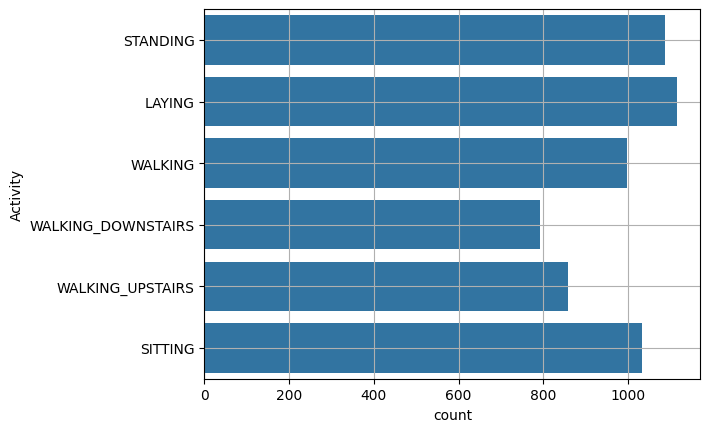

In [386]:
sns.countplot(data_tr['Activity'])
plt.grid()
plt.show()

## 3.미션1 : 데이터 분석1

수많은 feature들을 모두 살펴보는 것은 과도한 시간과 노력이 필요합니다. 그래서 여러분은 **선택과 집중**을 해야 합니다.
* 1) **트리 모델을 생성**한 후 **변수 중요도**를 구합니다.   
    * random forest 알고리즘 사용을 권장합니다.
* 2) **중요한 feature 상위 N개를 선정**하고, 이들을 대상으로 EDA 수행.
* 3) **각 feature 그룹별 중요도**도 파악해보며 EDA를 수행  
    * Feature 이름에는 계층구조를 담고 있습니다. 그렇다 보니 feature들을 적절하게 그룹으로 묶을 수 있습니다.
    * 참고로, feature 그룹의 중요도는 개별 feature 중요도의 합으로 계산할 수 있습니다.

### (1) 기본모델링 + 변수중요도 추출

* **세부 요구사항**
    - 모델링을 위한 기본 전처리를 수행합니다.
        - 주어진 데이터에서는 x, y로 나누고 train과 validation 분할 수행
    - 트리기반 알고리즘을 이용하여 모델링을 합니다.
        - 랜덤포레스트 권장 : 랜덤포레스트는 튜닝 없이 하이퍼파리미터의 기본값로도 적절한 성능의 모델을 생성할 수 있습니다.
    - 변수 중요도 추출
        - 사용자정의함수로 생성한 plot_feature_importance 을 이용
        - 변수중요도 파악및 결과 저장

#### 1) 데이터 전처리

In [392]:
# 데이터 전처리(타겟 설정)
target = 'Activity'

# x, y 선언
x = data_tr.drop(columns=target)
y = data_tr.loc[:,target]

# train, validation 분할
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.3, random_state=1)

#### 2) 모델링

In [394]:
# 모델 선언
model = RandomForestClassifier()

# 학습
model.fit(x_train, y_train)


RandomForestClassifier()

#### 3) 변수 중요도 추출

,feature_name,feature_importance
0,tGravityAcc-energy()-X,0.047075
1,tGravityAcc-mean()-Y,0.032737
2,tGravityAcc-min()-X,0.030971
3,tGravityAcc-min()-Y,0.026025
4,"angle(Y,gravityMean)",0.024686
...,...,...
556,"fBodyAcc-bandsEnergy()-49,56.2",0.000080
557,"tBodyAccJerk-arCoeff()-Y,2",0.000078
558,"fBodyGyro-bandsEnergy()-49,64.1",0.000071
559,"fBodyAcc-bandsEnergy()-33,40.1",0.000069


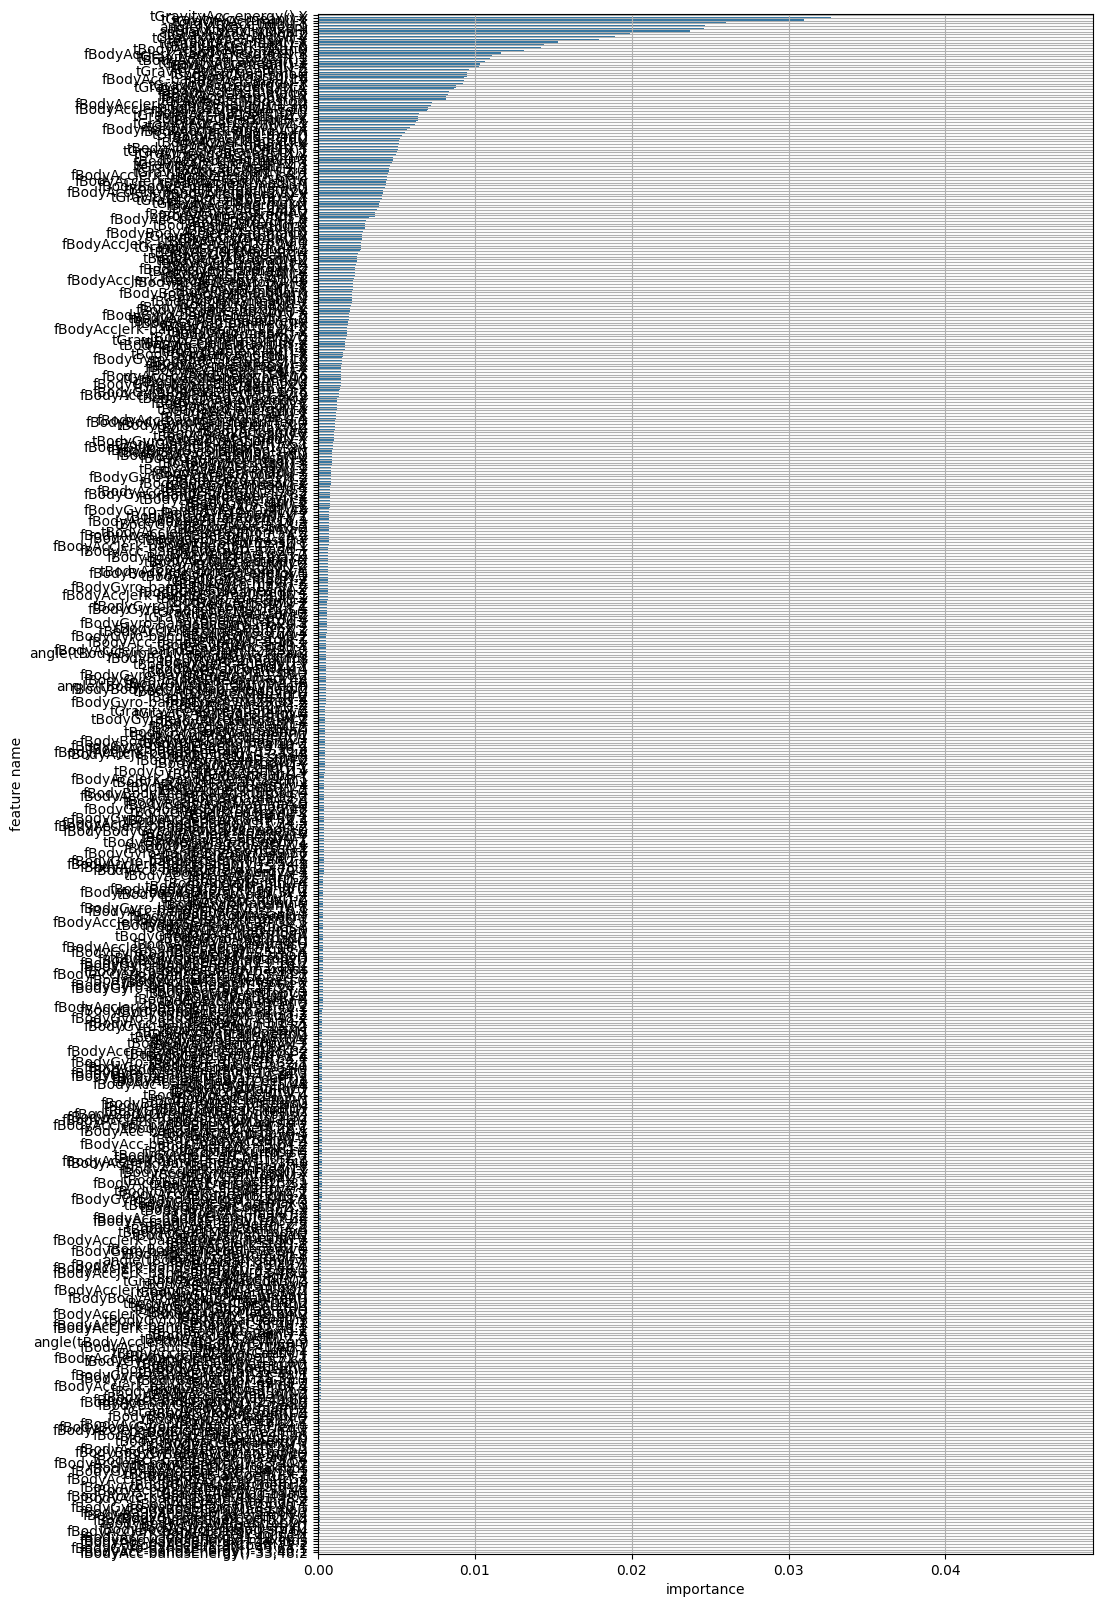

In [396]:
plot_feature_importance(model.feature_importances_, x_train.columns, result_only = False, topn = 'all')

### (2) 중요도 기반 feature 분석

* **세부 요구사항**
    - 상위 n, 하위 m 개의 변수를 선정
    - 선정된 변수(feature)와 target 간의 관계를 kdeplot으로 그리기

#### 1) 상위 5, 하위 5개 변수 선정

In [400]:
up_5 = ['angle(X,gravityMean)', 'tGravityAcc-energy()-X', 'tGravityAcc-mean()-X', 'tGravityAcc-min()-X', 'tGravityAcc-mean()-Y']

In [401]:
down_5 = ['fBodyBodyGyroMag-entropy()', 'tBodyAccJerkMag-max()', 'fBodyAcc-bandsEnergy()-33,48.1', 'fBodyBodyGyroJerkMag-mean()', 'fBodyAccJerk-entropy()-Y']

#### 2) 상위 5개 변수에 대한 분석

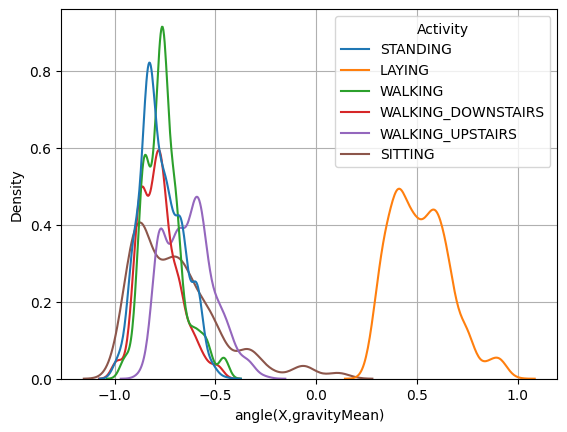

In [403]:
# angle(X,gravityMean)
feature = 'angle(X,gravityMean)'
target = 'Activity' # 미션2에서는 'is_Dynamic'
sns.kdeplot(x = feature, data = data_tr, hue = target)
plt.grid()
plt.show()

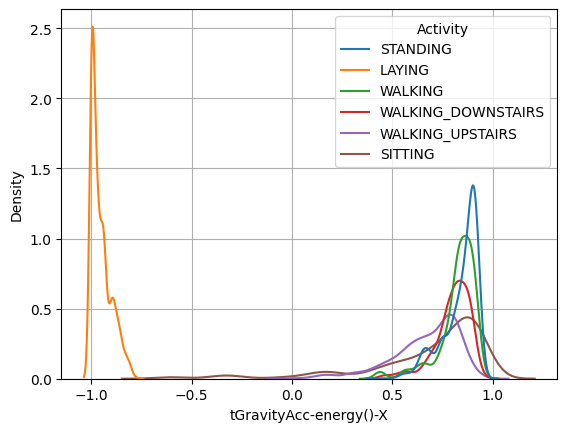

In [404]:
# tGravityAcc-energy()-X
feature = 'tGravityAcc-energy()-X'
target = 'Activity' # 미션2에서는 'is_Dynamic'
sns.kdeplot(x = feature, data = data_tr, hue = target)
plt.grid()
plt.show()

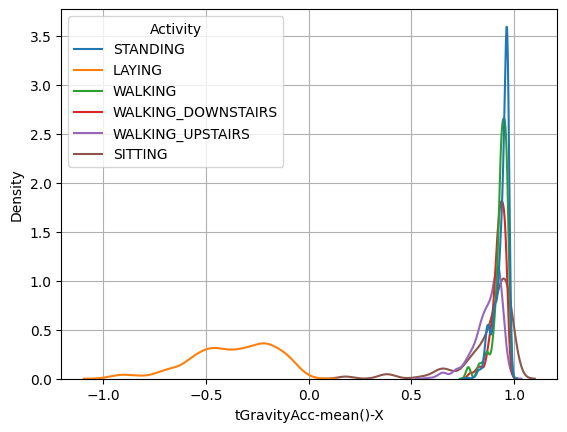

In [405]:
# tGravityAcc-mean()-X
feature = 'tGravityAcc-mean()-X'
target = 'Activity' # 미션2에서는 'is_Dynamic'
sns.kdeplot(x = feature, data = data_tr, hue = target)
plt.grid()
plt.show()

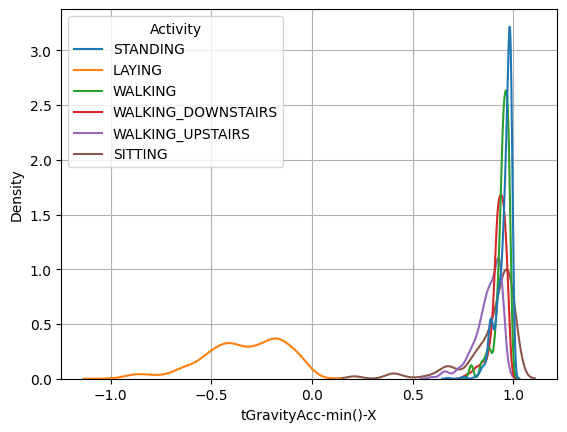

In [406]:
# tGravityAcc-min()-X
feature = 'tGravityAcc-min()-X'
target = 'Activity' # 미션2에서는 'is_Dynamic'
sns.kdeplot(x = feature, data = data_tr, hue = target)
plt.grid()
plt.show()

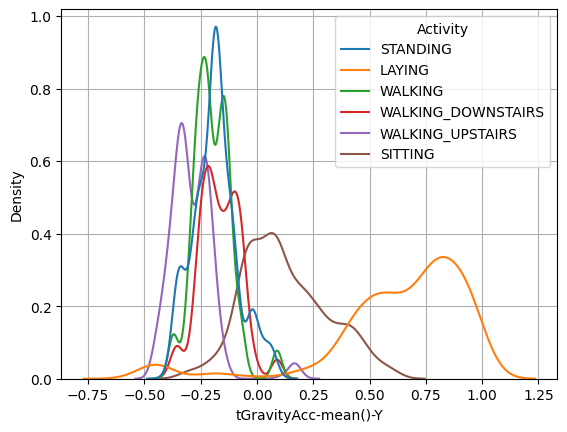

In [407]:
# tGravityAcc-mean()-Y
feature = 'tGravityAcc-mean()-Y'
target = 'Activity' # 미션2에서는 'is_Dynamic'
sns.kdeplot(x = feature, data = data_tr, hue = target)
plt.grid()
plt.show()

#### 3) 하위 5개 변수에 대한 분석

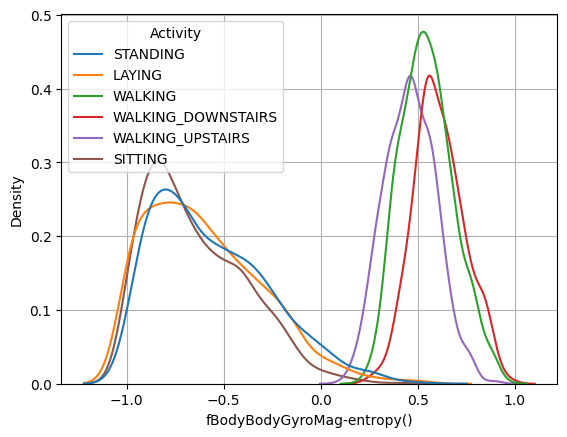

In [409]:
# fBodyBodyGyroMag-entropy()
feature = 'fBodyBodyGyroMag-entropy()'
target = 'Activity' # 미션2에서는 'is_Dynamic'
sns.kdeplot(x = feature, data = data_tr, hue = target)
plt.grid()
plt.show()

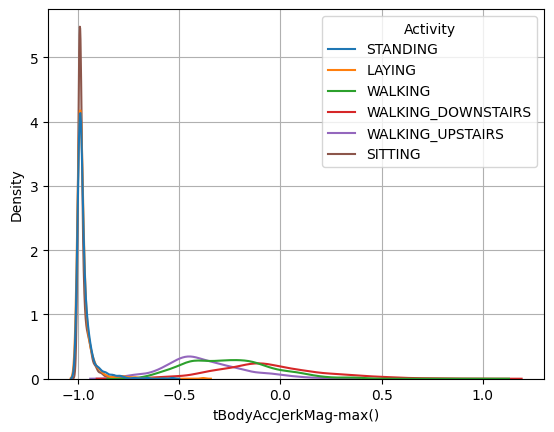

In [410]:
# tBodyAccJerkMag-max()
feature = 'tBodyAccJerkMag-max()'
target = 'Activity' # 미션2에서는 'is_Dynamic'
sns.kdeplot(x = feature, data = data_tr, hue = target)
plt.grid()
plt.show()

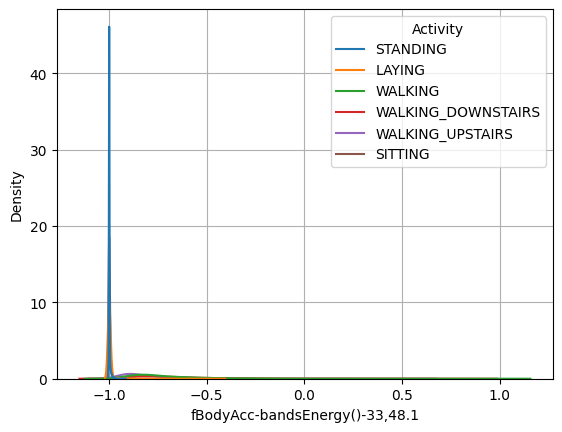

In [411]:
# fBodyAcc-bandsEnergy()-33,48.1
feature = 'fBodyAcc-bandsEnergy()-33,48.1'
target = 'Activity' # 미션2에서는 'is_Dynamic'
sns.kdeplot(x = feature, data = data_tr, hue = target)
plt.grid()
plt.show()

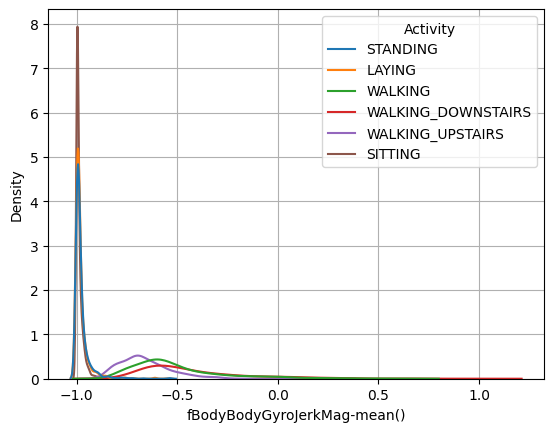

In [412]:
# fBodyBodyGyroJerkMag-mean()
feature = 'fBodyBodyGyroJerkMag-mean()'
target = 'Activity' # 미션2에서는 'is_Dynamic'
sns.kdeplot(x = feature, data = data_tr, hue = target)
plt.grid()
plt.show()

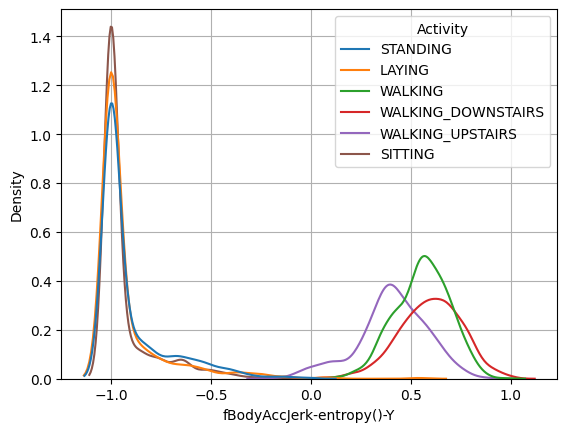

In [413]:
# fBodyAccJerk-entropy()-Y
feature = 'fBodyAccJerk-entropy()-Y'
target = 'Activity' # 미션2에서는 'is_Dynamic'
sns.kdeplot(x = feature, data = data_tr, hue = target)
plt.grid()
plt.show()

## 4.미션2 : 데이터 분석2

다음의 case에 맞게 feature 및 feature 그룹 중요도를 기반으로 탐색적 데이터 분석을 수행하시오.
* Target을 **정적/동적 행동**으로 구분
    * 6개의 행동은 2개의 그룹(정적행동, 동적행동)으로 나뉩니다.  
    * 어떤 feature(혹은 feature 그룹)이 2개 class 그룹(정적행동, 동적행동)를 구분하는데 중요한지를 찾아보고 탐색해봅시다.

### (1) 정적/동적 행동으로 구분하여 분석하기

* **세부 요구사항**
    - Target인 Activity를 is_dynamic 변수로 변경하시오.
        * 값 0 : STANDING, SITTING, LAYING
        * 값 1 : WALKING, WALKING_UPSTAIRS, WALKING_DOWNSTAIRS
    - is_dynamic을 예측하기 위한 기본 모델을 생성하시오.
        * x, is_dynamic을 이용하여 train과 validation으로 데이터 분할
        * 기본 모델링
    - is_dynamic 을 구분하는데 중요한 변수 상위 5를 분석하시오.



#### 1) is_dynamic 추가

In [419]:
data_tr['is_dynamic'] = data_tr['Activity'].map({'STANDING': 0, 'SITTING': 0, 'LAYING': 0, 'WALKING': 1, 'WALKING_UPSTAIRS': 1, 'WALKING_DOWNSTAIRS': 1})
data_tr.head()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",Activity,is_dynamic
0,0.288508,-0.009196,-0.103362,-0.988986,-0.962797,-0.967422,-0.989000,-0.962596,-0.965650,-0.929747,...,-0.816696,-0.042494,-0.044218,0.307873,0.072790,-0.601120,0.331298,0.165163,STANDING,0
1,0.265757,-0.016576,-0.098163,-0.989551,-0.994636,-0.987435,-0.990189,-0.993870,-0.987558,-0.937337,...,-0.693515,-0.062899,0.388459,-0.765014,0.771524,0.345205,-0.769186,-0.147944,LAYING,0
2,0.278709,-0.014511,-0.108717,-0.997720,-0.981088,-0.994008,-0.997934,-0.982187,-0.995017,-0.942584,...,-0.829311,0.000265,-0.525022,-0.891875,0.021528,-0.833564,0.202434,-0.032755,STANDING,0
3,0.289795,-0.035536,-0.150354,-0.231727,-0.006412,-0.338117,-0.273557,0.014245,-0.347916,0.008288,...,-0.408956,-0.255125,0.612804,0.747381,-0.072944,-0.695819,0.287154,0.111388,WALKING,1
4,0.394807,0.034098,0.091229,0.088489,-0.106636,-0.388502,-0.010469,-0.109680,-0.346372,0.584131,...,-0.563437,-0.044344,-0.845268,-0.974650,-0.887846,-0.705029,0.264952,0.137758,WALKING_DOWNSTAIRS,1


In [420]:
data_tr.dtypes

tBodyAcc-mean()-X       float64
tBodyAcc-mean()-Y       float64
tBodyAcc-mean()-Z       float64
tBodyAcc-std()-X        float64
tBodyAcc-std()-Y        float64
                         ...   
angle(X,gravityMean)    float64
angle(Y,gravityMean)    float64
angle(Z,gravityMean)    float64
Activity                 object
is_dynamic                int64
Length: 563, dtype: object

In [421]:
# 가변수화
dumm_cols = ['Activity']
data_tr = pd.get_dummies(data_tr, columns=dumm_cols, drop_first=True, dtype=int)

#### 2) 기본모델 생성

In [423]:
# 데이터 전처리(타겟 설정)
target = 'is_dynamic'

# x, y 선언
x = data_tr.drop(columns=target)
is_dynamic = data_tr.loc[:,target]

# train, validation 분할
x_train, x_val, is_dynamic_train, is_dynamic_val = train_test_split(x, y, test_size=0.3, random_state=1)

In [424]:
# 모델 선언
model = RandomForestClassifier()

# 학습
model.fit(x_train, is_dynamic_train)

RandomForestClassifier()

#### 3) 변수중요도 상위 5개 분석

,feature_name,feature_importance
0,Activity_STANDING,0.050821
1,Activity_SITTING,0.044493
2,tGravityAcc-energy()-X,0.044104
3,Activity_WALKING,0.033749
4,tGravityAcc-mean()-X,0.033609
...,...,...
561,"fBodyAcc-bandsEnergy()-49,56.2",0.000032
562,"tBodyAccJerk-arCoeff()-Y,2",0.000031
563,"tBodyGyro-arCoeff()-X,3",0.000031
564,"fBodyAcc-bandsEnergy()-25,48.1",0.000030


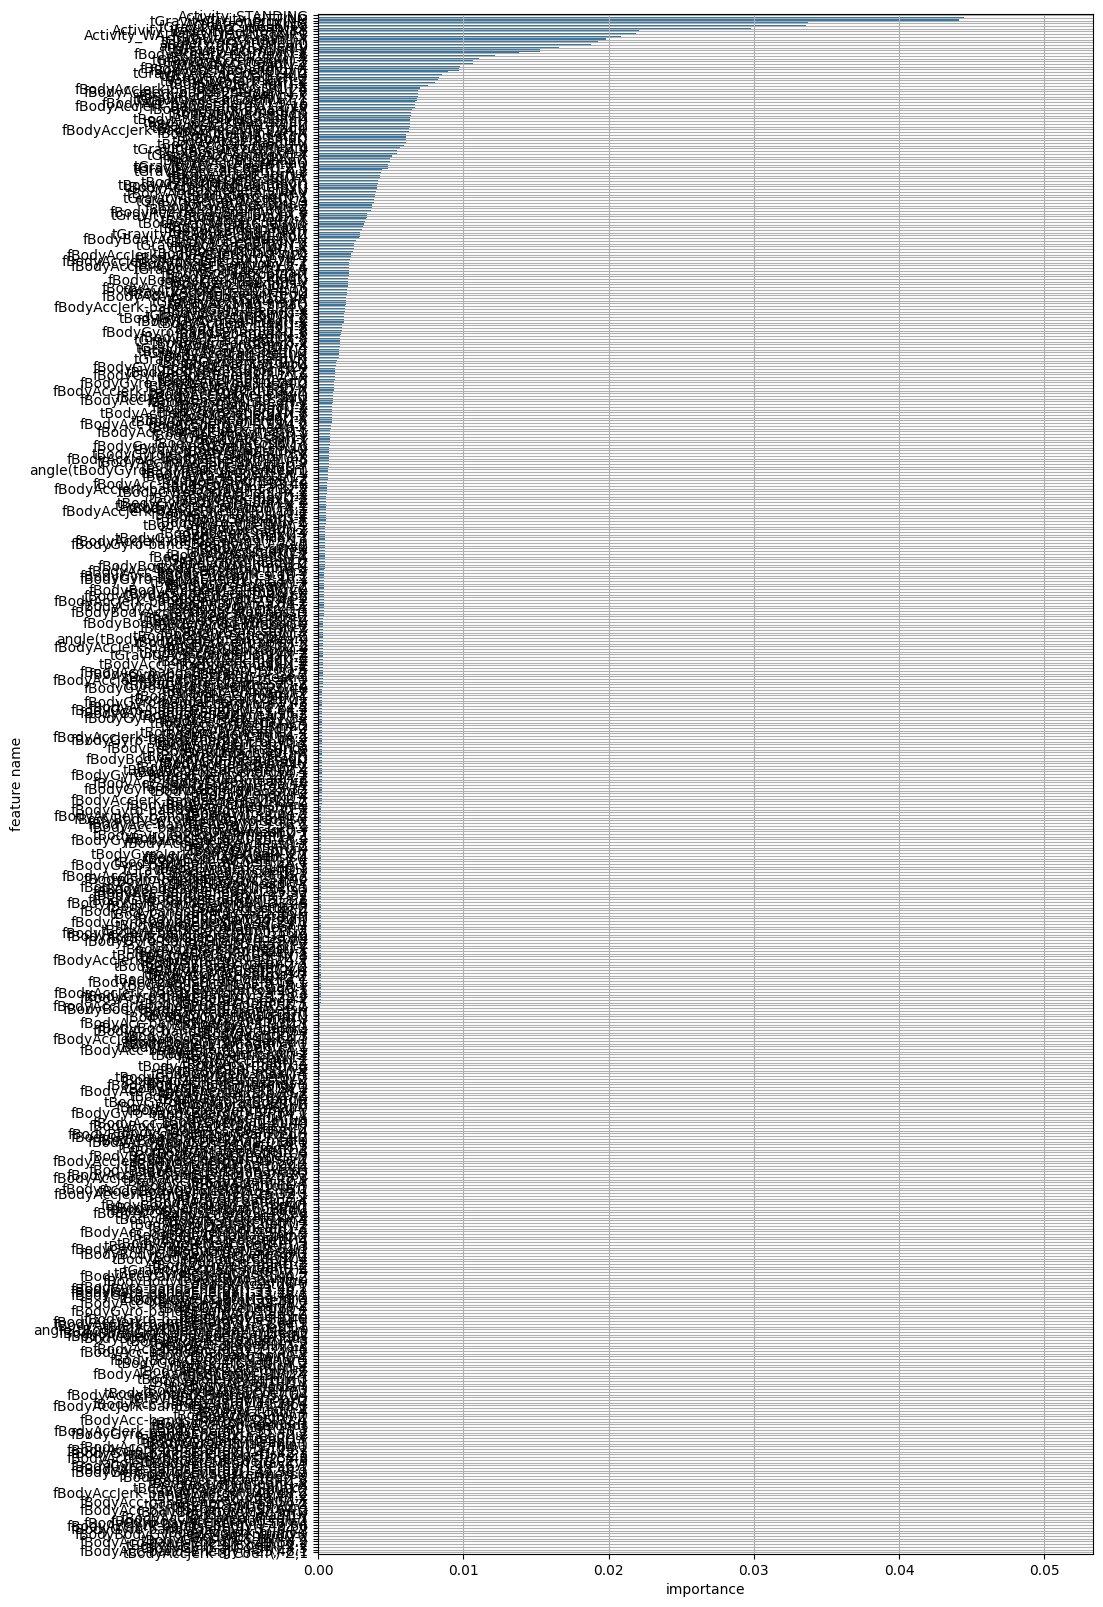

In [426]:
# 변수중요도 추출
plot_feature_importance(model.feature_importances_, x_train.columns, result_only = False, topn = 'all')

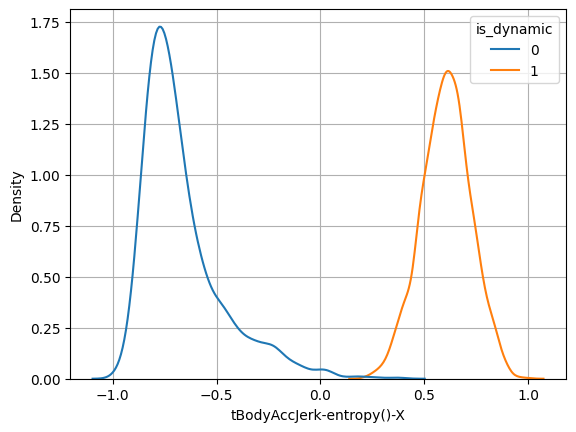

In [427]:
# tBodyAccJerk-entropy()-X
feature = 'tBodyAccJerk-entropy()-X'
target = 'is_dynamic' # 미션2에서는 'is_Dynamic'
sns.kdeplot(x = feature, data = data_tr, hue = target)
plt.grid()
plt.show()

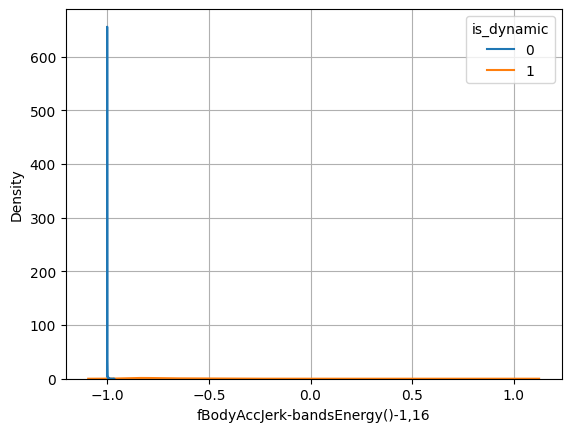

In [428]:
# fBodyAccJerk-bandsEnergy()-1,16
feature = 'fBodyAccJerk-bandsEnergy()-1,16'
target = 'is_dynamic' # 미션2에서는 'is_Dynamic'
sns.kdeplot(x = feature, data = data_tr, hue = target)
plt.grid()
plt.show()

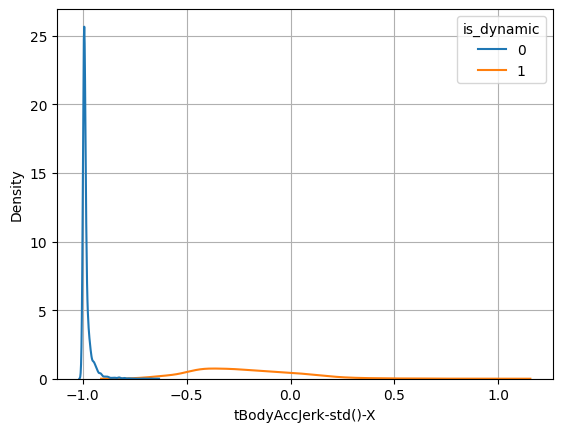

In [429]:
# tBodyAccJerk-std()-X
feature = 'tBodyAccJerk-std()-X'
target = 'is_dynamic' # 미션2에서는 'is_Dynamic'
sns.kdeplot(x = feature, data = data_tr, hue = target)
plt.grid()
plt.show()

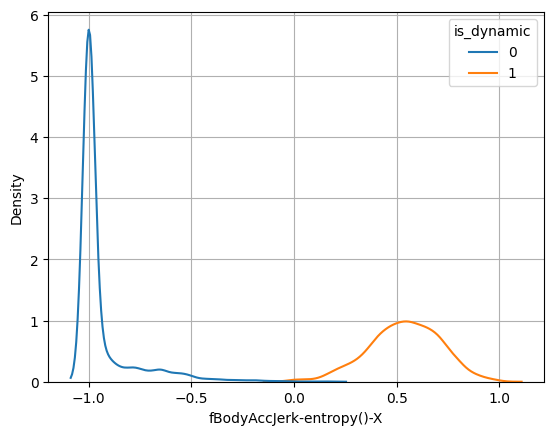

In [430]:
# fBodyAccJerk-entropy()-X
feature = 'fBodyAccJerk-entropy()-X'
target = 'is_dynamic' # 미션2에서는 'is_Dynamic'
sns.kdeplot(x = feature, data = data_tr, hue = target)
plt.grid()
plt.show()

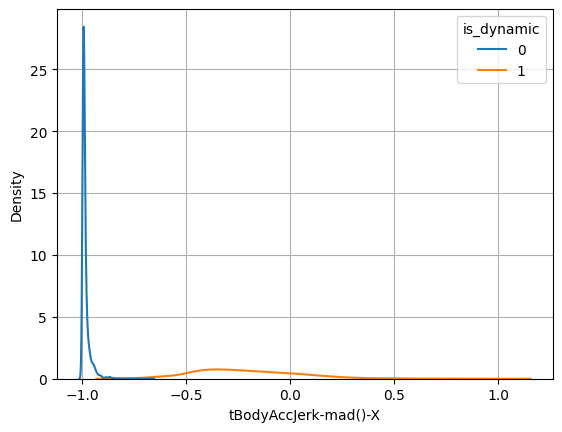

In [328]:
# tBodyAccJerk-mad()-X
feature = 'tBodyAccJerk-mad()-X'
target = 'is_dynamic' # 미션2에서는 'is_Dynamic'
sns.kdeplot(x = feature, data = data_tr, hue = target)
plt.grid()
plt.show()